# Дорогой дневник

--------------------------------------------

1) Сначала я решил попробовать без генерации новых фичей и без подкрутки параметров запустить LightGBM и посмотреть, что будет. Скор 0.720
При этом пока еще нет ни генерации новых признаков, ни использования таблицы поиска и тд. Попробуем добавить.

2) Просто запускаем код из "baseline_1_pandas.ipynb" и получаем обещаный скор 0.817

3) Оптюнил 10 минут, безрезультатно. Буду придумывать новые признаки. Думаю начать с кластеризации и knn. 

4) Сначала решил просто расширить плавающее окно с 4 до 5 месяцев, результат 0.8192.

    Есть огромное количество идей, только что заменил пандас на поларс, потому что он реально на порядок быстрее. В первую очередь хочется применить знания с семинара по интерпретации бустингов, но сначала заменить катбуст на lgbm, ибо Илья утверждал, что при должном обращении он рвет и мечет.

--------------------------------------------

# Другой подход к кластеризации

Пробуем новую идею, если не получается кластеризовать все обьекты, будем делать так: мы же уже знаем какие есть кластеры, просто раздадим метки по ключевым словам, олценим сколько осталось и проведем еще одну кластеризацию. 

In [47]:
import polars as pl
import pandas as pd
import numpy as np
import catboost
import os
from datetime import date, timedelta
from itertools import combinations

from local_utils import *
import lightgbm as lgb

%load_ext autoreload
%autoreload 2

test_start_date = date(2024, 8, 1)
val_start_date = date(2024, 7, 1)
val_end_date = date(2024, 7, 31)
train_end_date = date(2024, 6, 30)
data_path = "C:\\Users\\Admin\\Desktop\\AIM 2сем\\ML2\\hw2"

actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet')).collect()
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet')).collect()
widget_info = pl.read_csv(os.path.join(data_path, 'widget_info.csv'))
product_information = pl.read_csv(
    os.path.join(data_path, 'cluster_product_information.csv'),
    ignore_errors=True
)

val_target = (
    actions_history
    .filter(pl.col('timestamp').dt.date() >= val_start_date)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .select('user_id', (pl.col('action_type_id') == 3).alias('has_order'))
    .group_by('user_id')
    .agg(pl.max('has_order').cast(pl.Int32).alias('target'))
)

val_target.group_by('target').agg(pl.count('user_id'))

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


target,user_id
i32,u32
0,1227381
1,647575


In [48]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для последующего создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с указанием суффиксов
combined = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined = combined.join(
        agg, 
        on='user_id', 
        how='left',
        suffix=f"_{i}"  # Добавляем уникальный суффикс для каждого соединения
    )

In [49]:
# search_aggs
id_ = 4
suf = 'search'

# Сначала вычислим value_counts отдельно и развернем их в плоскую структуру
cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров (мера разнообразия)
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров (процент повторяющихся)
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(val_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(val_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\276488151.py:52: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [50]:
product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= train_end_date)
    .filter(pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [51]:
train_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < val_start_date) &  # до валидации
        (pl.col('timestamp').dt.date() >= val_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общая активность
        pl.count().alias('total_actions_30d'),
        
        # Разбивка по типам действий
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        # Финансовые метрики
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        # Временные характеристики (исправлено!)
        (val_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        # Метрики кластеров
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        # Производные признаки
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\1964511306.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\1964511306.py:31: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [52]:
# Виджеты
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= train_end_date) &
        (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
            (pl.col('timestamp').dt.date() <= train_end_date) &
            (pl.col('timestamp').dt.date() >= train_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\790935654.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\790935654.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [53]:
df_main = val_target
for _, actions_aggs_df in actions_aggs.items():
    df_main = (
        df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )

df_main = df_main.join(product_cluster_aggs, on='user_id', how='left')
df_main = df_main.join(train_last_month_features, on='user_id', how='left')
df_main = df_main.join(widget_aggs, on='user_id', how='left')

df_main = df_main.with_columns([
    pl.col('last_click_time').dt.hour().alias('last_click_hour'),
    pl.col('last_order_time').dt.weekday().alias('last_order_weekday'),
])

df_main = df_main.with_columns([
    (pl.col('last_order_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_order_days'),
    (pl.col('last_favorite_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_favorite_days')
])

df_main = df_main.with_columns([
    (pl.col('main_search_cluster') == pl.col('main_product_cluster')).alias('main_cluster_match'),
    pl.col('top3_search_clusters').list.contains(pl.col('main_product_cluster')).alias('product_cluster_in_search_top3')
])

df_main = df_main.with_columns([
    (pl.col('num_products_order') / pl.col('num_products_click')).alias('click_to_order_rate'),
    (pl.col('num_products_to_cart') / pl.col('num_products_click')).alias('click_to_cart_rate')
]).fill_null(0)

df_main = df_main.with_columns([
    (pl.col('days_since_first_click') > 30).alias('is_long_term_user'),
    (pl.col('days_since_last_click') < 7).alias('is_active_user')
])

df_main = df_main.with_columns([
    (pl.col('sum_discount_price_order') / pl.col('days_since_first_order')).alias('spending_rate')
])

df_pd = df_main.to_pandas()

columns_to_log = ['max_discount_price_click', 'num_products_favorite', 'sum_discount_price_favorite', 'max_discount_price_favorite',  'num_products_order', 'sum_discount_price_order', 'sum_discount_price_order',  'num_products_to_cart', 'max_discount_price_to_cart', 'num_search', 'unique_search_queries', 'num_search_last_month', 'num_search_last_week', 'search_daily_rate', 'search_cluster_switches', 'search_mean_query_len', 'search_main_cluster_query_len_diff']

df_pd = apply_log_transform(df_pd, columns_to_log, drop_original=True)

df_pd['main_cluster_match'] = (
    df_pd['main_cluster_match']
    .map({True: 1, False: 0, None: -1, np.nan: -1})
    .astype(int)  # Чтобы точно получить int (иначе может остаться float)
)

In [54]:
knn_cols = ['days_since_first_order', 'days_since_last_order', 'sum_discount_price_to_cart', 'num_products_click', 'main_search_cluster', 'search_cluster_stability', 'product_cluster_stability', 'widget_3_ratio', 'widget_21_ratio', 'widget_7_ratio', 'widget_12_ratio', 'widget_4_ratio', 'active_days_30d']

#df_pd = add_knn_features_faiss(df_pd, knn_cols, n_neighbors=5, use_gpu=True)

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

------------------------------------------------------

In [55]:
actions_aggs = {}
actions_id_to_suf = {
    1: "click",
    2: "favorite", 
    3: "order",
    5: "to_cart",
}

# Сначала соберем все агрегированные данные
all_aggs = []
numeric_features = []

for id_, suf in actions_id_to_suf.items():
    aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= val_end_date)
        .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
        .filter(pl.col('action_type_id') == id_)
        .join(
            product_information.select('product_id', 'discount_price'),
            on='product_id',
        )
        .group_by('user_id')
        .agg(
            pl.count('product_id').cast(pl.Int32).alias(f'num_products_{suf}'),
            pl.sum('discount_price').cast(pl.Float32).alias(f'sum_discount_price_{suf}'),
            pl.max('discount_price').cast(pl.Float32).alias(f'max_discount_price_{suf}'),
            pl.max('timestamp').alias(f'last_{suf}_time'),
            pl.min('timestamp').alias(f'first_{suf}_time'),
        )
        .with_columns([
            (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),
            
            (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
        ])
    )
    
    # Сохраняем имена числовых фичей для создания полиномов
    numeric_features.extend([
        f'num_products_{suf}',
        f'sum_discount_price_{suf}', 
        f'max_discount_price_{suf}',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
    ])
    
    actions_aggs[id_] = aggs
    all_aggs.append(aggs)

# Объединяем все агрегации по user_id с суффиксами
combined_val = all_aggs[0]
for i, agg in enumerate(all_aggs[1:], 1):
    combined_val = combined_val.join(
        agg, 
        on='user_id', 
        how='outer',
        suffix=f"_{i}"
    )

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\2116881979.py:59: DeprecationWarning: Use of `how='outer'` should be replaced with `how='full'`.
  combined_val = combined_val.join(


In [56]:
id_ = 4
suf = 'search'

# Вычисляем top3 кластеров для валидации (аналогично трейну)
val_cluster_counts = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        pl.col('cluster').value_counts().alias('cluster_counts')
    )
    .explode('cluster_counts')
    .with_columns(
        pl.col('cluster_counts').struct.field('cluster').alias('cluster_name'),
        pl.col('cluster_counts').struct.field('count').alias('cluster_count')
    )
    .group_by('user_id')
    .agg(
        pl.col('cluster_name').sort_by('cluster_count', descending=True).head(3).alias('top3_clusters'),
        pl.col('cluster_count').sort(descending=True).head(3).alias('top3_counts')
    )
)

actions_aggs[id_] = (
    search_history
    .filter(pl.col('action_type_id') == id_)
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .group_by('user_id')
    .agg(
        # Общее количество поисков за 5 месяцев
        pl.count('search_query').cast(pl.Int32).alias(f'num_{suf}'),
        pl.col('search_query').n_unique().alias(f'unique_{suf}_queries'),
        
        # Количество поисков за последний месяц (30 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_month'),
        
        # Количество поисков за последнюю неделю (7 дней)
        pl.col('search_query')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=7))
            .count()
            .cast(pl.Int32)
            .alias(f'num_{suf}_last_week'),

        (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),

        pl.col('cluster').n_unique().alias(f'num_{suf}_clusters'),
        pl.col('cluster').mode().first().alias(f'main_{suf}_cluster'),
        
        # Динамика кластеров
        pl.col('cluster')
            .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30))
            .mode().first()
            .alias(f'recent_{suf}_cluster'),

        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias(f'{suf}_cluster_concentration'),
        
        # Энтропия кластеров
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias(f'{suf}_cluster_entropy'),
        
        # Переключения между кластерами
        pl.col('cluster').diff().fill_null(0).abs().sum().alias(f'{suf}_cluster_switches'),
        
        # Стабильность кластеров
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias(f'{suf}_cluster_stability'),
        
        # Время в основном кластере
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count())
            .alias(f'main_{suf}_cluster_time_ratio'),

        pl.col('timestamp').filter(pl.col('cluster').diff().fill_null(0) != 0)
            .diff()
            .dt.total_days()
            .mean()
            .alias(f'{suf}_mean_cluster_switch_days'),

        pl.col('search_query').str.len_chars().mean().alias(f'{suf}_mean_query_len'),
        
        (pl.col('search_query').str.len_chars()
            .filter(pl.col('cluster') == pl.col('cluster').mode().first()).mean() - 
            pl.col('search_query').str.len_chars()
                .filter(pl.col('cluster') != pl.col('cluster').mode().first()).mean())
                .alias(f'{suf}_main_cluster_query_len_diff'),

        pl.max('timestamp').alias(f'last_{suf}_time'),
        pl.min('timestamp').alias(f'first_{suf}_time'),
    )
    .join(val_cluster_counts, on='user_id', how='left')
    .with_columns([
        (pl.lit(test_start_date) - pl.col(f'last_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_last_{suf}'),

        (pl.lit(test_start_date) - pl.col(f'first_{suf}_time'))
            .dt.total_days()
            .cast(pl.Int32)
            .alias(f'days_since_first_{suf}'),
    ])
    .select(
        'user_id',
        f'num_{suf}',
        f'unique_{suf}_queries',
        f'num_{suf}_last_month',
        f'num_{suf}_last_week',
        f'{suf}_daily_rate',
        f'num_{suf}_clusters',
        f'main_{suf}_cluster',
        pl.col('top3_clusters').alias(f'top3_{suf}_clusters'),
        pl.col('top3_counts').alias(f'top3_{suf}_counts'),
        f'recent_{suf}_cluster',
        f'{suf}_cluster_concentration',
        f'{suf}_cluster_entropy',
        f'{suf}_cluster_switches',
        f'{suf}_cluster_stability',
        f'main_{suf}_cluster_time_ratio',
        f'{suf}_mean_cluster_switch_days',
        f'{suf}_mean_query_len',
        f'{suf}_main_cluster_query_len_diff',
        f'days_since_last_{suf}',
        f'days_since_first_{suf}',
        f'last_{suf}_time',
        f'first_{suf}_time',
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\555555092.py:51: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.count() / (pl.max('timestamp') - pl.min('timestamp')).dt.total_days()).alias(f'{suf}_daily_rate'),


In [57]:
val_product_cluster_aggs = (
    actions_history
    .filter(pl.col('timestamp').dt.date() <= val_end_date)
    .filter(pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5))
    .join(
        product_information.select('product_id', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Общие агрегаты по кластерам продуктов
        pl.col('cluster').n_unique().alias('num_product_clusters'),
        pl.col('cluster').mode().first().alias('main_product_cluster'),
        
        # Аналогичные агрегаты как для search
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.col('cluster').count()).alias('product_cluster_concentration'),
        
        # Энтропия кластеров продуктов
        (-(pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count()).log()
            * (pl.col('cluster').value_counts().struct.field('count') / pl.col('cluster').count())
            .sum()).alias('product_cluster_entropy'),
        
        # Стабильность кластеров продуктов
        ((pl.col('cluster').count() - pl.col('cluster').n_unique()) / pl.col('cluster').count())
            .alias('product_cluster_stability'),
        
        # Время в основном кластере продуктов
        (pl.col('timestamp')
            .filter(pl.col('cluster') == pl.col('cluster').mode().first())
            .count() / pl.col('timestamp').count()
        ).alias('main_product_cluster_time_ratio'),
            
        # Top 3 кластеров продуктов
        pl.col('cluster').value_counts().struct.field('cluster').alias('top_product_clusters'),
        pl.col('cluster').value_counts().struct.field('count').alias('top_product_counts')
    )
    .with_columns(
        pl.col('top_product_clusters').list.head(3).alias('top3_product_clusters'),
        pl.col('top_product_counts').list.head(3).alias('top3_product_counts')
    )
    .drop(['top_product_clusters', 'top_product_counts'])
)

In [58]:
test_last_month_features = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() < test_start_date) &  # до теста
        (pl.col('timestamp').dt.date() >= test_start_date - timedelta(days=30))  # последние 30 дней
    )
    .join(
        product_information.select('product_id', 'discount_price', 'cluster'),
        on='product_id'
    )
    .group_by('user_id')
    .agg(
        # Те же метрики, что и для трейна
        pl.count().alias('total_actions_30d'),
        (pl.col('action_type_id') == 1).sum().alias('clicks_30d'),
        (pl.col('action_type_id') == 2).sum().alias('favorites_30d'),
        (pl.col('action_type_id') == 5).sum().alias('cart_adds_30d'),
        
        pl.sum('discount_price').alias('total_spent_30d'),
        pl.mean('discount_price').alias('avg_price_30d'),
        
        (test_start_date - pl.col('timestamp').max().dt.date()).dt.total_days().alias('days_since_last_action'),
        (pl.col('timestamp').max() - pl.col('timestamp').min()).dt.total_days().alias('active_days_30d'),
        
        pl.col('cluster').n_unique().alias('unique_clusters_30d'),
        (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')
    )
    .with_columns(
        (pl.col('total_actions_30d') / pl.col('active_days_30d')).alias('daily_actions_rate_30d'),
        (pl.col('cart_adds_30d') / pl.col('total_actions_30d')).alias('cart_add_ratio_30d'),
        (pl.col('favorites_30d') / pl.col('total_actions_30d')).alias('favorite_ratio_30d')
    )
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\4126633476.py:14: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('total_actions_30d'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\4126633476.py:26: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('cluster').value_counts().struct.field('count').max() / pl.count()).alias('main_cluster_ratio_30d')


In [59]:
# Сначала получим список реально существующих виджетов
existing_widgets = (
    actions_history
    .filter(pl.col('widget_name_id').is_not_null())
    .select(pl.col('widget_name_id').unique())
    .to_series()
    .to_list()
)

# Теперь создаем агрегаты только для существующих виджетов
widget_aggs = (
    actions_history
    .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
        (pl.col('widget_name_id').is_not_null())
    )
    .group_by(['user_id', 'widget_name_id'])
    .agg(
        pl.count().alias('widget_count')
    )
    .join(
        actions_history
        .filter(
        (pl.col('timestamp').dt.date() <= val_end_date) &
        (pl.col('timestamp').dt.date() >= val_end_date - timedelta(days=30 * 5)) &
            (pl.col('widget_name_id').is_not_null())
        )
        .group_by('user_id')
        .agg(pl.count().alias('total_widget_actions')),
        on='user_id'
    )
    .with_columns(
        (pl.col('widget_count') / pl.col('total_widget_actions')).alias('widget_ratio')
    )
    .group_by('user_id')
    .agg([
        *[pl.col('widget_count').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_count') 
          for widget_id in existing_widgets],
        *[pl.col('widget_ratio').filter(pl.col('widget_name_id') == widget_id).first().alias(f'widget_{widget_id}_ratio') 
          for widget_id in existing_widgets]
    ])
    .fill_null(0)
)

if 'total_widget_actions' in widget_aggs.columns:
    widget_aggs = widget_aggs.drop('total_widget_actions')

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\2057899543.py:20: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  pl.count().alias('widget_count')
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\2057899543.py:30: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  .agg(pl.count().alias('total_widget_actions')),


In [60]:
from local_utils import *

test_users_submission = (
    pl.read_csv(os.path.join(data_path, 'test_users.csv'))
)

test_df_main = test_users_submission
for _, actions_aggs_df in actions_aggs.items():
    test_df_main = (
        test_df_main
        .join(actions_aggs_df, on='user_id', how='left')
    )
test_df_main = test_df_main.join(val_product_cluster_aggs, on='user_id', how='left')
test_df_main = test_df_main.join(test_last_month_features, on='user_id', how='left')
test_df_main = test_df_main.join(widget_aggs, on='user_id', how='left')


test_df_main = test_df_main.with_columns([
    pl.col('last_click_time').dt.hour().alias('last_click_hour'),
    pl.col('last_order_time').dt.weekday().alias('last_order_weekday'),
])

test_df_main = test_df_main.with_columns([
    (pl.col('last_order_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_order_days'),
    (pl.col('last_favorite_time') - pl.col('last_click_time')).dt.total_days().alias('click_to_favorite_days')
])

test_df_main = test_df_main.with_columns([
    (pl.col('main_search_cluster') == pl.col('main_product_cluster')).alias('main_cluster_match'),
    pl.col('top3_search_clusters').list.contains(pl.col('main_product_cluster')).alias('product_cluster_in_search_top3')
])

test_df_main = test_df_main.with_columns([
    (pl.col('num_products_order') / pl.col('num_products_click')).alias('click_to_order_rate'),
    (pl.col('num_products_to_cart') / pl.col('num_products_click')).alias('click_to_cart_rate')
]).fill_null(0)

test_df_main = test_df_main.with_columns([
    (pl.col('days_since_first_click') > 30).alias('is_long_term_user'),
    (pl.col('days_since_last_click') < 7).alias('is_active_user')
])

test_df_main = test_df_main.with_columns([
    (pl.col('sum_discount_price_order') / pl.col('days_since_first_order')).alias('spending_rate')
])


test_df_pd = test_df_main.to_pandas()

test_df_pd = apply_log_transform(test_df_pd, columns_to_log, drop_original=True)

In [61]:
#test_df_pd = add_knn_features_faiss(test_df_pd, knn_cols, n_neighbors=5, use_gpu=True)

In [62]:
def add_time_pattern_features(df_pd, actions_history, product_info):
    # Конвертируем product_info в LazyFrame если нужно
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    time_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            ((pl.col('timestamp').dt.hour() >= 6) & (pl.col('timestamp').dt.hour() < 12)).alias('new_is_morning'),
            ((pl.col('timestamp').dt.hour() >= 12) & (pl.col('timestamp').dt.hour() < 18)).alias('new_is_day'),
            (pl.col('timestamp').dt.weekday() >= 5).alias('new_is_weekend'),
            (pl.col('timestamp').dt.hour()).alias('new_hour'),
            (pl.col('timestamp').dt.weekday()).alias('new_dow')
        ])
        .join(
            product_info_lazy.select(['product_id', 'discount_price']), 
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
            (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
            (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
            pl.col('new_hour').value_counts().struct.field('count').entropy().alias('new_hour_entropy'),
            (pl.col('new_dow').filter(pl.col('new_dow') < 5).count() / 
             (pl.col('new_dow').filter(pl.col('new_dow') >= 5).count() + 1e-6)).alias('new_weekday_weekend_ratio'),
            (pl.col('discount_price').filter(pl.col('new_is_morning')).sum() / 
            (pl.col('new_is_morning').sum() + 1e-6)).alias('new_morning_avg_spend')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(time_aggs, on='user_id', how='left')

In [63]:
def add_brand_category_features(df_pd, actions_history, product_info):
    product_info_lazy = product_info.lazy() if isinstance(product_info, pl.DataFrame) else product_info
    
    brand_aggs = (
        actions_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .join(
            product_info_lazy.select(['product_id', 'brand', 'category_id', 'discount_price']),
            on='product_id',
            how='left'
        )
        .group_by('user_id')
        .agg(
            pl.col('brand').n_unique().alias('new_unique_brands'),
            (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
            pl.col('category_id').n_unique().alias('new_unique_categories'),
            pl.col('category_id').value_counts().struct.field('count').max().alias('new_favorite_category_count'),
            (pl.col('discount_price').filter(pl.col('category_id') == 
             pl.col('category_id').mode().first()).mean()).alias('new_main_category_avg_price')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(brand_aggs, on='user_id', how='left')

In [64]:
def add_search_features(df_pd, search_history):
    search_aggs = (
        search_history
        .filter(pl.col('timestamp').dt.date() <= train_end_date)
        .with_columns([
            pl.col('search_query').str.split(' ').list.len().alias('new_query_word_count'),  # Исправлено здесь
            pl.col('search_query').str.contains(r'\d').alias('new_has_numbers')
        ])
        .group_by('user_id')
        .agg(
            pl.mean('new_query_word_count').alias('new_avg_query_length'),
            (pl.sum('new_has_numbers') / pl.count()).alias('new_numeric_query_ratio'),
            pl.col('search_query').filter(pl.col('search_query').str.len_chars() > 20).count().alias('new_long_queries_count')
        )
        .collect()
        .to_pandas()
    )
    
    return df_pd.merge(search_aggs, on='user_id', how='left')

In [65]:
# Загрузите данные заново (если нужно)
actions_history = pl.scan_parquet(os.path.join(data_path, 'actions_history/*.parquet'))
search_history = pl.scan_parquet(os.path.join(data_path, 'cluster_search/*.parquet'))
product_info = product_information

# Добавляем новые признаки
df_pd = add_time_pattern_features(df_pd, actions_history, product_info)
df_pd = add_brand_category_features(df_pd, actions_history, product_info) 
df_pd = add_search_features(df_pd, search_history)

test_df_pd['main_cluster_match'] = (
    test_df_pd['main_cluster_match']
    .map({True: 1, False: 0, None: -1, np.nan: -1})
    .astype(int)
)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\2438321060.py:12: Dep

In [66]:
test_df_pd = add_time_pattern_features(test_df_pd, actions_history, product_info)
test_df_pd = add_brand_category_features(test_df_pd, actions_history, product_info) 
test_df_pd = add_search_features(test_df_pd, search_history)

C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:22: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_morning') / pl.count()).alias('new_morning_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:23: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_day') / pl.count()).alias('new_day_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\703708266.py:24: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.sum('new_is_weekend') / pl.count()).alias('new_weekend_activity_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\600433880.py:15: DeprecationWarning: `pl.count()` is deprecated. Please use `pl.len()` instead.
  (pl.col('brand').value_counts().struct.field('count').max() / pl.count()).alias('new_favorite_brand_ratio'),
C:\Users\Admin\AppData\Local\Temp\ipykernel_150688\2438321060.py:12: Dep

In [75]:
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]

lgb_tr, lgb_val = get_split(df_pd, val_size=0.35)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 'last_favorite_time', 'first_favorite_time', 
                                  'last_order_time', 'first_order_time', 'last_to_cart_time', 'first_to_cart_time', 'last_search_time', 'first_search_time',
                                  'top3_search_clusters', 'top3_search_counts', 'search_cluster_entropy', 'top3_product_counts', 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params={
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',

    'max_depth': 7,

    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

lgb_model = train_model_new(lgb_tr, lgb_val, cols, 'target', params=lgb_params, shadow_features=False, sklearn_style=True)

[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 421323, number of negative: 797397
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.162405 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 21757
[LightGBM] [Info] Number of data points in the train set: 1218720, number of used features: 122
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345709 -> initscore=-0.637953
[LightGBM] [Info] Start training from score -0.637953
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds
[100]	train's auc: 0.76585	valid's auc

feature_importance: [107 119   8 194 145   0 219 108 116  51  32  67  94  24  45  65  62 103
 186 128 127 122  51   0   5  18  99  93 156  97 173  16  85  39  21 124
 223   8  67  33 133  54  49  66   4  68 119 122  85  18 109  98  82  90
  74  54  32  84  53   0  16   8  66  75  43   0 181  70  85  10   1  55
   1 156   4 117  48   7  54  50 292 143   0   7  47  57 204  88 170   0
  80  41 136 118 189  57  54  94  63  55 104  79   2   0 133 107 121 126
  17  90  16  61  92  37  66  39 125  56  89 135   0  35 223  75] 



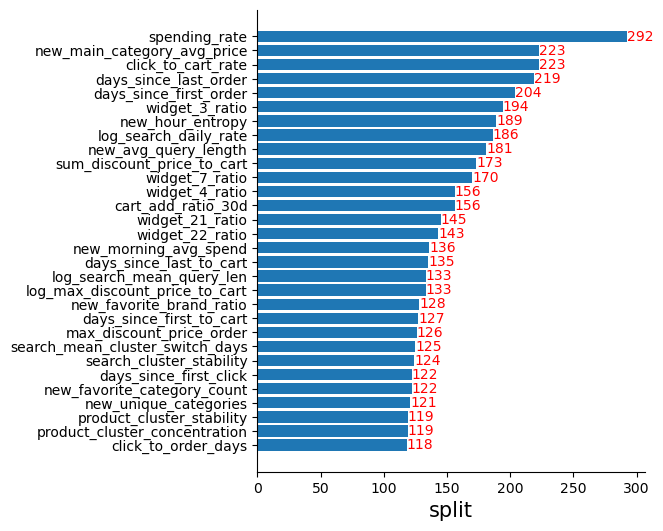

In [76]:
from local_utils import *

print('feature_importance:', lgb_model.feature_importances_, '\n')

plot_lgbm_importance(lgb_model, cols, importance_type='split', top_k=30, sklearn_style=True)

In [69]:
ы

NameError: name 'ы' is not defined

In [80]:
import numpy as np
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from local_utils import *

df_pd = df_pd[df_pd['user_id'] != 2346229]
lgb_tr, lgb_val = get_split(df_pd, val_size=0.37)

cols = list(set(df_pd.columns) - {'user_id', 'target', 'last_click_time', 'first_click_time', 
                                 'last_favorite_time', 'first_favorite_time', 
                                 'last_order_time', 'first_order_time', 
                                 'last_to_cart_time', 'first_to_cart_time', 
                                 'last_search_time', 'first_search_time',
                                 'top3_search_clusters', 'top3_search_counts', 
                                 'search_cluster_entropy', 'top3_product_counts', 
                                 'product_cluster_entropy', 'top3_product_clusters'})

lgb_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.1,
    'boosting_type': 'gbdt',
    'max_depth': 7,
    'num_iterations': 400,
    'early_stopping_rounds': 100,
    'verbose': 1,
    'importance_type': 'split'
}

n_models = 14
feature_frac = 0.78


feature_subsets = []
remaining_features = set(cols.copy())

for i in range(n_models):
    if remaining_features:
        # Берем часть еще неиспользованных фичей
        n_new_features = max(1, int(len(remaining_features) / (n_models - i)))
        new_features = np.random.choice(list(remaining_features), n_new_features, replace=False)
        remaining_features -= set(new_features)
        
        # Добираем случайными фичами до 70%
        n_additional = int(len(cols) * feature_frac) - len(new_features)
        additional_features = np.random.choice(
            [f for f in cols if f not in new_features], 
            n_additional, 
            replace=False
        )
        
        feature_subset = list(new_features) + list(additional_features)
    else:
        # Все фичи уже использованы, просто берем случайные 70%
        feature_subset = np.random.choice(cols, int(len(cols) * feature_frac), replace=False)
    
    feature_subsets.append(feature_subset)

# Обучаем базовые модели и собираем их предсказания
base_models = []
train_predictions = np.zeros((len(lgb_tr), n_models))
val_predictions = np.zeros((len(lgb_val), n_models))

for i, feature_subset in enumerate(feature_subsets):
    print(f"Training base model {i+1} on {len(feature_subset)} features...")
    
    # Обучаем модель на подвыборке фичей
    model = train_model_new(
        lgb_tr, 
        lgb_val, 
        feature_subset, 
        'target', 
        params=lgb_params, 
        shadow_features=False, 
        sklearn_style=True
    )
    base_models.append(model)
    
    # Получаем предсказания на трейне и валидации
    train_predictions[:, i] = model.predict_proba(lgb_tr[feature_subset])[:, 1]
    val_predictions[:, i] = model.predict_proba(lgb_val[feature_subset])[:, 1]

Training base model 1 on 96 features...
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] Number of positive: 408377, number of negative: 772844
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.106605 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 16682
[LightGBM] [Info] Number of data points in the train set: 1181221, number of used features: 94
[LightGBM] [Warning] early_stopping_round is set=100, early_stopping_rounds=100 will be ignored. Current value: early_stopping_round=100
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345724 -> initscore=-0.637886
[LightGBM] [Info] Start training from score -0.637886
Training until validation scores don't improve for 100 rounds
Training until validation scores don't improve for 100 rounds

In [81]:
res = []
for i, m in enumerate(base_models):
    feature_subset = feature_subsets[i]
    res.append(m.predict_proba(test_df_pd[feature_subset])[:, 1])

In [82]:
# 1. Создаем DataFrame с предсказаниями (как в предыдущих шагах)
predictions_array = np.array(res).T
res_df = pd.DataFrame(predictions_array, columns=[f'Model_{i+1}' for i in range(len(res))])

# 2. Добавляем user_id из исходных данных
res_df['user_id'] = test_df_pd['user_id'].values  # или reset_index(), если нужно

# 3. Добавляем усредненное предсказание (если нужно)
res_df['predict'] = res_df[[f'Model_{i+1}' for i in range(len(res))]].mean(axis=1)

# 4. Сохраняем только нужные колонки
res_df

,Model_1,Model_2,Model_3,Model_4,Model_5,Model_6,Model_7,Model_8,Model_9,Model_10,Model_11,Model_12,Model_13,Model_14,user_id,predict
0,0.177529,0.165777,0.178435,0.172343,0.196584,0.169879,0.185491,0.177193,0.201725,0.220647,0.171438,0.189515,0.176462,0.176571,1342,0.182828
1,0.773971,0.762999,0.802698,0.703012,0.719706,0.717255,0.728357,0.763311,0.738507,0.801163,0.716360,0.806511,0.756747,0.760124,9852,0.753623
2,0.221550,0.219676,0.214941,0.216073,0.224680,0.211904,0.216734,0.224147,0.219402,0.220925,0.218326,0.220973,0.229261,0.216003,10206,0.219614
3,0.233165,0.230952,0.232749,0.228466,0.220453,0.232208,0.230706,0.218555,0.217591,0.230529,0.232784,0.229496,0.223063,0.230544,11317,0.227947
4,0.627508,0.528149,0.567046,0.559153,0.565131,0.517271,0.532254,0.604352,0.533198,0.571798,0.551664,0.566637,0.575276,0.565830,13289,0.561805
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2068419,0.187236,0.181764,0.195011,0.189222,0.187680,0.188303,0.187495,0.183934,0.190211,0.186361,0.187493,0.189610,0.191017,0.187159,11157283,0.188035
2068420,0.043629,0.052852,0.044946,0.039582,0.051115,0.043133,0.057407,0.057942,0.040961,0.045624,0.055166,0.061374,0.035928,0.057121,11160395,0.049056
2068421,0.596059,0.608078,0.600421,0.531488,0.652004,0.618202,0.598367,0.602900,0.632317,0.639456,0.623305,0.627318,0.609637,0.583048,11165052,0.608757
2068422,0.482778,0.467793,0.501036,0.503105,0.452488,0.450518,0.481228,0.459745,0.450725,0.465951,0.458007,0.476125,0.487893,0.452148,11168218,0.470681


In [83]:
res_df[['user_id', 'predict']].to_csv('new_fe_10_mod.csv', index=False)

In [ ]:
train_predictions

array([[0.22547412, 0.25132468, 0.21476295, 0.18734984, 0.21438304],
       [0.1560645 , 0.14496159, 0.14636049, 0.15302676, 0.16567748],
       [0.14946189, 0.15212392, 0.14949851, 0.15217072, 0.14968099],
       ...,
       [0.19060726, 0.19075469, 0.1908499 , 0.1907798 , 0.19063895],
       [0.29317334, 0.29863873, 0.31216036, 0.29748104, 0.28861929],
       [0.11250568, 0.11662762, 0.12088134, 0.12235186, 0.11623842]])

In [ ]:
# Создаем датафреймы для мета-модели
meta_train = pd.DataFrame(train_predictions, columns=[f"model_{i}" for i in range(n_models)])
meta_train['target'] = lgb_tr['target'].values

meta_val = pd.DataFrame(val_predictions, columns=[f"model_{i}" for i in range(n_models)])
meta_val['target'] = lgb_val['target'].values

# Обучаем мета-модель (стекер) на предсказаниях базовых моделей
meta_features = [f"model_{i}" for i in range(n_models)]
meta_params = {
    'objective': 'binary',
    'metric': 'auc',
    'learning_rate': 0.05,  # Можно сделать меньше, чем у базовых
    'boosting_type': 'gbdt',
    'max_depth': 5,  # Меньше, чем у базовых
    'num_iterations': 200,
    'early_stopping_rounds': 50,
    'verbose': 1
}

print("Training meta-model...")
meta_model = train_model_new(
    meta_train,
    meta_val,
    meta_features,
    'target',
    params=meta_params,
    shadow_features=False,
    sklearn_style=True
)

# Функция для предсказаний ансамбля
def ensemble_predict(X):
    # Предсказания базовых моделей
    base_preds = np.zeros((X.shape[0], n_models))
    for i, (model, feature_subset) in enumerate(zip(base_models, feature_subsets)):
        base_preds[:, i] = model.predict(X[feature_subset])
    
    # Преобразуем в DataFrame как для мета-тренировки
    meta_input = pd.DataFrame(base_preds, columns=[f"model_{i}" for i in range(n_models)])
    
    # Предсказание мета-модели
    return meta_model.predict_proba(meta_input)[:, 1]

preds = ensemble_predict(test_df_pd[cols])
preds

Training meta-model...
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] Number of positive: 518009, number of negative: 981955
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.012848 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 1499964, number of used features: 5
[LightGBM] [Warning] early_stopping_round is set=50, early_stopping_rounds=50 will be ignored. Current value: early_stopping_round=50
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.345348 -> initscore=-0.639553
[LightGBM] [Info] Start training from score -0.639553
Training until validation scores don't improve for 50 rounds
Training until validation scores don't improve for 100 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Wa

array([0.03704448, 0.96242586, 0.03704448, ..., 0.96242586, 0.96242586,
       0.96242586])